<a href="https://colab.research.google.com/github/AreYouRuben/DS_Team24/blob/main/Analisis_Datos_Python_Santander/Final_F1_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Análisis de Datos con Python: Fórmula 1

Desde los tiempos de cada vuelta hasta el número de veces que el motor falla en una temporada o el tiempo de parada en los pits, la cantidad de datos recabados todos los años en la Fórmula 1 es enorme y de gran variedad. Fue precisamente por esta abundacia de datos y el interés que tenemos sobre este deporte que decidimos abordar este tema. Sin más preámbulos, nuestra pretensión es dar recomendaciones al equipo de RedBull Honda que le sirvan para mejorar su desempeño en las carreras. A fin de cuentas, la mejora de desempeño puede ser abordada desde tres acercamientos distintos:

1. **Mejoras del auto**
    * Reducir las fallas del auto
    * Evolución de los lapTimes del equipo a través del tiempo  
    
    
    
2. **Mejoras del conductor**
    * ¿Cuántos accidentes tienen los conductores de RedBull respecto a otros equipos?
    * Comparación de lapTimes entre dos pilotos de un mismo equipo para saber quién es mejor
    * Comparar desempeño de pilotos actuales con otros pilotos de sueldos similares para saber si por el mismo
      sueldo podemos obtener a un mejor conductor.
    * ¿Cómo se relaciona la posición final de la carrera con la posición de la clasifiación del piloto?
    
    
    
    
3. **Mejoras de estrategia**
    * ¿Cuál es la distribución del tiempo en los pits del equipo y como se compara con otros equipos?
    * La estrategia óptima de selección de llantas

## Importación de datos
Antes de comenzar el análisis de nuestros datos vamos a importar las bases de datos que serán utilizadas en el proyecto.

In [ ]:
# Importamos las bibliotecas que serán utilizadas
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import altair as alt
import ipywidgets as widgets
from vega_datasets import data
import folium
!pip install pycountry
import pycountry
from sklearn.linear_model import LinearRegression
import math
from scipy.stats import skew, kurtosis

In [ ]:
path ='https://raw.githubusercontent.com/AreYouRuben/DS_Team24/main/Analisis_Datos_Python_Santander/f1_dataset/'
filenames = ["circuits",
             "constructor_results","constructor_standings",
            "constructors",
             "driver_standings",
             "drivers","lap_times",
             "pit_stops",
             "qualifying",
             "races",
             "results"
             ,"seasons",
             "status"]

dfs = []
for filename in filenames:
  complete_path = path + filename + ".csv"
  #print(complete_path)
  df = pd.read_csv(complete_path, encoding="latin1")
  dfs.append(df)

df_dictionary = {}
for filename in filenames:
  complete_path = path + filename + ".csv"
  df_dictionary[filename] = pd.read_csv(complete_path, encoding="latin1")

### Contexto F1


In [ ]:
data_country = df_dictionary['circuits']
data_country = data_country.merge(df_dictionary['races'], left_on = 'circuitId', right_on = 'circuitId')
data_country = data_country.groupby('country').size().reset_index()
data_country.rename(columns={0: 'Races'}, inplace=True)
#data_country

In [ ]:
input_countries = data_country['country']

countries = {}
for country in pycountry.countries:
    countries[country.name] = country.alpha_3

codes = [countries.get(country, 'Unknown code') for country in input_countries]
data_country['country_codes'] = [countries.get(country, 'Unknown code') for country in input_countries]
data_country.replace('Unknown code', np.nan, inplace=True)
data_country.update(data_country['country_codes'].fillna(data_country['country']))
#data_country

In [ ]:
import plotly.graph_objects as go

df = data_country
fig = go.Figure(data=go.Choropleth(
    locations=df['country_codes'],
    z=df['Races'].astype(float),
    colorscale='ice_r',
    autocolorscale=False,
    text=df['country'], # hover text
    marker_line_color='white', # line markers between states
    #colorbar_title="Races"
))
fig.update_geos(projection_type="natural earth",lataxis_showgrid=True, lonaxis_showgrid=True)
fig.update_layout(
    title_text='Races per country since 1950'
)

fig.show()

El mapa representa el número de carreras por cada país desde 1950

In [ ]:

# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
# ATENCIÓN: Al filtrar el mapa con la lista de opciones
# Asegurarse de que esta sea la última celda que se ejecutó
# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

source = df_dictionary['drivers'][['driverId','driverRef','code']]


stock_picker = widgets.SelectMultiple(
    options=source.code.unique(),
    value=list(source.code.unique()),
    description='Corredor')

@widgets.interact(code=stock_picker)
def render(code):
  selected = source[source.code.isin(list(code))]  
  selected.code.values[0]
  data_map = df_dictionary['circuits']
  data_map = data_map.merge(df_dictionary['races'], left_on = 'circuitId', right_on = 'circuitId')
  data_map = data_map[data_map['year']>2009]
  data_map = data_map.merge(df_dictionary['results'], left_on = 'raceId', right_on = 'raceId')
  data_map = data_map[data_map['driverId'] == selected.driverId.values[0]]

  data_map = data_map.loc[data_map.groupby('circuitId')['points'].agg(pd.Series.idxmax)]
  
  m = folium.Map(location=[20,0], tiles="OpenStreetMap", zoom_start=2)
  for i in range(0,len(data_map)):
    html=f"""
      <h1> {data_map.iloc[i]['name_x']}</h1>
      <ul>
          <li>{str.upper(selected.driverRef.values[0])} {data_map.iloc[i]['points']}</li>
      </ul>
      </p>
      <p>Ver carrera en <a href="{data_map.iloc[i]['url_y']}">Wikipedia</a></p>
      """
    iframe = folium.IFrame(html=html, width=500, height=200)
    popup = folium.Popup(iframe, max_width=2650)
    

    folium.Circle(
      location=[data_map.iloc[i]['lat'], data_map.iloc[i]['lng']],
      popup = popup,
      #popup=('Points: ' + str(data_map.iloc[i]['points']) + '\n' + 'Circuit: ' + data_map.iloc[i]['name_x']),
      icon=folium.DivIcon(html=f"""
          <div><svg>
              <circle cx="50" cy="50" r="40" fill="#69b3a2" opacity=".4"/>
              <rect x="35", y="35" width="30" height="30", fill="red", opacity=".3" 
          </svg></div>"""),
      radius=float(data_map.iloc[i]['points'])*20000,
      color='crimson',
      fill=True,
      fill_color='crimson'
      ).add_to(m)
  return m
# Checo 815: PER

interactive(children=(SelectMultiple(description='Corredor', index=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, …

Las burbujas en el mapa representan los puntos obtenidos por el piloto. El tamaño de la burbuja aumenta conforme el piloto obtenga más puntos. Al dar clic en la burbuja, se abre un popup con información de la carrera y un link de la misma

### 1. Mejoras del auto

#### 1.1 Fallas del auto
Las fallas en el auto no sólo retrasan el tiempo de carrera sino que implican un gasto adicional al ya costoso presupuesto de un equipo de Fórmula 1. Como parte del equipo de RedBull nos gustaría saber el número de fallas de nuestros autos y su frecuencia comparada con los fallas de otros equipos. La tabla **fallas** que se presenta a continuación tiene un atributo llamado *status* que identifica el tipo de falla que experimentó el auto en la carrera.

In [ ]:
fallas = df_dictionary['results'].merge(df_dictionary['status'], left_on = 'statusId', right_on = 'statusId') # Añadimos la descripción del estatus
fallas = fallas.merge(df_dictionary['constructors'], left_on = 'constructorId', right_on = 'constructorId') # Añadimos el nombre del equipo
fallas = fallas.merge(df_dictionary['races'], left_on = 'raceId', right_on = 'raceId')
fallas = fallas[['raceId','year', 'name_x', 'status']] # Utilizamos sólo los datos que nos importan
fallas = fallas[fallas['year'].isin([2011, 2012, 2013, 2014, 2015,2016,2017,2018,2019,2020])] # Seleccionamos los registros de los ultimos 10 años
lista_equipos = ['McLaren', 'Ferrari', 'Red Bull', 'Mercedes', 'Renault']
lista_fallas = ['Power Unit',
               'Breaks',
               'Engine',
               'Electornics',
               'Gearbox',
               'Overheating',
               'Puncture',
               'Transmission',
               'Exhaust',
               'Radiator',
               'Suspension',
               'Fuel pressure'] 

fallas = fallas[fallas['status'].isin(lista_fallas)] # Nos fijamos sólo en los status que denotan fallas mecánicas
fallas = fallas[fallas['name_x'].isin(lista_equipos)] #Seleccionamos a los equipos de interés

Observemos primero los datos que contiene la tabla **fallas**.

In [ ]:
fallas.head()

,raceId,year,name_x,status
11838,845,2011,Ferrari,Gearbox
11871,846,2011,Mercedes,Engine
11992,851,2011,Mercedes,Gearbox
12126,857,2011,Ferrari,Suspension
12152,858,2011,Red Bull,Puncture


In [ ]:
ct = pd.crosstab(fallas.name_x, fallas.status, margins = True)
ct

status,Engine,Exhaust,Fuel pressure,Gearbox,Overheating,Power Unit,Puncture,Radiator,Suspension,Transmission,All
name_x,,,,,,,,,,,
Ferrari,3,0,0,1,0,1,0,0,2,0,7
McLaren,9,3,2,10,0,8,0,0,3,0,35
Mercedes,4,0,2,3,0,3,2,0,1,0,15
Red Bull,7,1,0,3,0,4,3,1,2,1,22
Renault,7,1,0,5,3,2,0,0,2,0,20
All,30,5,4,22,3,18,5,1,10,1,99


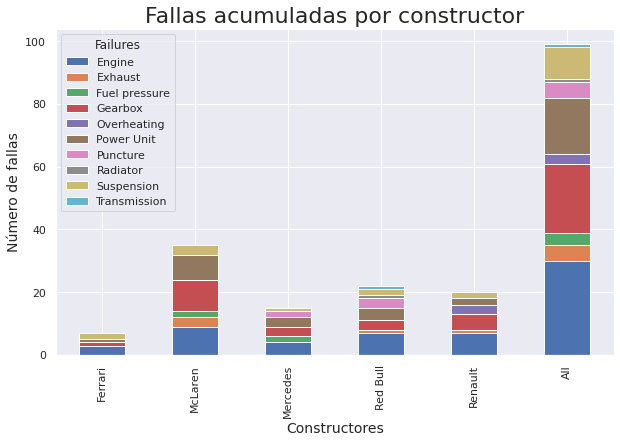

In [ ]:
ct.drop('All', inplace=True, axis=1)
plt.rcParams['figure.figsize']= 10,6
ct.plot.bar(stacked=True)
plt.legend(title='Failures')
plt.xlabel('Constructores', fontsize=14)
plt.ylabel('Número de fallas', fontsize=14)
plt.title('Fallas acumuladas por constructor', fontsize=22)
plt.show()

**Observaciones:** Red Bull es el segundo equipo con mayor número de fallas mecánicas. Las fallas en el motor son las más frecuentes en la mayoría de los equipos y Red Bull no es la excepción. Comparando a Red Bull con Ferrari hay una diferencia de 15 fallas mecánicas en las carreras en los últimos 10 años. Las fallas que sufrió Ferrari representan sólo el 31% del total de fallas de Red Bull. Si omitimos a Ferrari, la frecuencia de las fallas mecánicas de Redd Bull ya no es tan descabellada si se le compara con los restantes 3 competidores. Así pues, si queremos no sólo mejorar el desempeño del automóvil sino también reducir costos de reparación debemos preguntarnos, ¿qué está haciendo Ferrari diferente de Red Bull y los demás equipos que logra que sus autos casi nunca presenten fallas mecánicas?

#### 1.2 Evolución de los lapTimes de Checo Pérez a través del tiempo

In [ ]:
# Analizar los tiempos que ha hecho Checo Pérez en el circuito de Bahrain (Comparación de sus tiempos de carrera)
tiempos_vueltas = df_dictionary['lap_times'].merge(df_dictionary['races'], left_on = 'raceId', right_on = 'raceId')
tiempos_vueltas_ano = tiempos_vueltas.loc[(tiempos_vueltas["driverId"]==815) & (tiempos_vueltas["circuitId"]==3)].groupby(['year']) 
tiempos_vueltas_ano.head(10)

,raceId,driverId,lap,position,time_x,milliseconds,year,round,circuitId,name,date,time_y,url
28124,863,815,1,10,1:48.091,108091,2012,4,3,Bahrain Grand Prix,2012-04-22,12:00:00,http://en.wikipedia.org/wiki/2012_Bahrain_Gran...
28125,863,815,2,10,1:42.201,102201,2012,4,3,Bahrain Grand Prix,2012-04-22,12:00:00,http://en.wikipedia.org/wiki/2012_Bahrain_Gran...
28126,863,815,3,10,1:43.238,103238,2012,4,3,Bahrain Grand Prix,2012-04-22,12:00:00,http://en.wikipedia.org/wiki/2012_Bahrain_Gran...
28127,863,815,4,11,1:42.467,102467,2012,4,3,Bahrain Grand Prix,2012-04-22,12:00:00,http://en.wikipedia.org/wiki/2012_Bahrain_Gran...
28128,863,815,5,11,1:41.546,101546,2012,4,3,Bahrain Grand Prix,2012-04-22,12:00:00,http://en.wikipedia.org/wiki/2012_Bahrain_Gran...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
491879,1052,815,6,14,1:37.480,97480,2021,1,3,Bahrain Grand Prix,2021-03-28,15:00:00,https://en.wikipedia.org/wiki/2021_Bahrain_Gra...
491880,1052,815,7,14,1:37.891,97891,2021,1,3,Bahrain Grand Prix,2021-03-28,15:00:00,https://en.wikipedia.org/wiki/2021_Bahrain_Gra...
491881,1052,815,8,13,1:37.134,97134,2021,1,3,Bahrain Grand Prix,2021-03-28,15:00:00,https://en.wikipedia.org/wiki/2021_Bahrain_Gra...
491882,1052,815,9,13,1:37.381,97381,2021,1,3,Bahrain Grand Prix,2021-03-28,15:00:00,https://en.wikipedia.org/wiki/2021_Bahrain_Gra...


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).



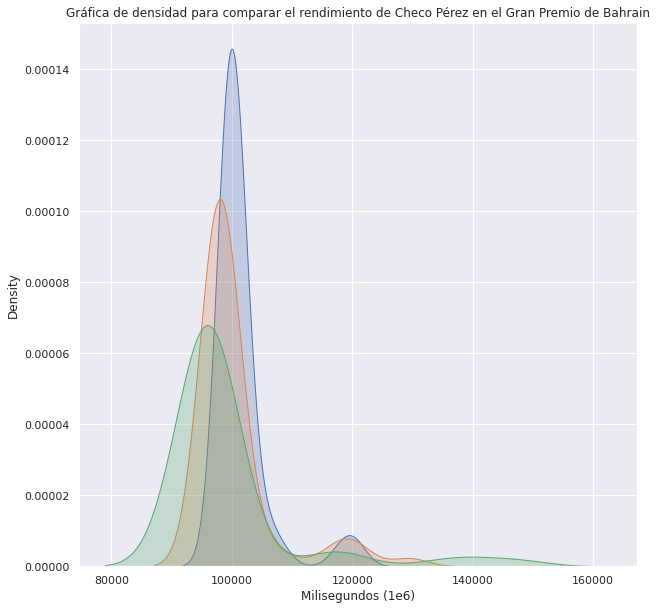

In [ ]:
# Imprimir los resultados de sus vueltas al inicio de su carrera (línea azul), en el 2019 (línea naranja) y ahora con Red Bull (línea verde)
plt.figure(figsize=(10, 10))
tiempos_vueltas_ano_2012 = tiempos_vueltas_ano.get_group(2012)
tiempos_vueltas_ano_2019 = tiempos_vueltas_ano.get_group(2019)
tiempos_vueltas_ano_2021 = tiempos_vueltas_ano.get_group(2021)
#for name, group in tiempos_vueltas_ano:
ax = sns.distplot(tiempos_vueltas_ano_2012["milliseconds"], hist = False, kde_kws = {'shade': True})
ax = sns.distplot(tiempos_vueltas_ano_2019["milliseconds"], hist = False, kde_kws = {'shade': True})
ax = sns.distplot(tiempos_vueltas_ano_2021["milliseconds"], hist = False, kde_kws = {'shade': True})
ax.set_title('Gráfica de densidad para comparar el rendimiento de Checo Pérez en el Gran Premio de Bahrain')
ax.set(xlabel='Milisegundos (1e6)');

### 2. Mejoras del conductor

#### 2.1 Accidentes de los conductores de Red Bull respecto a otros equipos

In [ ]:
# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
# ATENCIÓN: Al filtrar el mapa con la lista de opciones
# Asegurarse de que esta sea la última celda que se ejecutó
# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

# Análisis del estatus que han obtenido los corredores en sus carreras

source = df_dictionary['drivers']

stock_picker = widgets.SelectMultiple(
    options=source.code.unique(),
    value=list(source.code.unique()),
    description='code')

@widgets.interact(code=stock_picker)
def render(code):
  selected = source[source.code.isin(list(code))] 
  status_de_carrera = df_dictionary['results'].merge(df_dictionary['status'], left_on = 'statusId', right_on = 'statusId') # Añadimos la descripción del estatus
  status_de_carrera = status_de_carrera.merge(df_dictionary['drivers'], left_on = 'driverId', right_on = 'driverId')
  count_checo_status = status_de_carrera[status_de_carrera["code"]==selected.code.values[0]]["status"].value_counts()
  # Mostramos porcentajes
  as_percentages = count_checo_status * 100 / count_checo_status.sum()

  plt.figure(figsize=(10, 10))
  sns.set_theme(style="whitegrid")
  ax = sns.barplot(y=as_percentages.index, x=as_percentages, orient='h')
  ax.set_title('Porcentaje de cómo un corredor ha terminado sus carreras de F1')
  ax.set(xlabel='Porcentaje');

interactive(children=(SelectMultiple(description='code', index=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, …

In [ ]:
# Agrupamos los resultados con base en el status para analizar la relación con su posición inicial de carrera
status_de_carrera = df_dictionary['results'].merge(df_dictionary['status'], left_on = 'statusId', right_on = 'statusId') # Añadimos la descripción del estatus
count_checo_status_equipo = status_de_carrera[status_de_carrera["driverId"]==815].groupby(['status']).apply(lambda x: x.reset_index(drop=True)).drop(['status'],axis=1).reset_index()


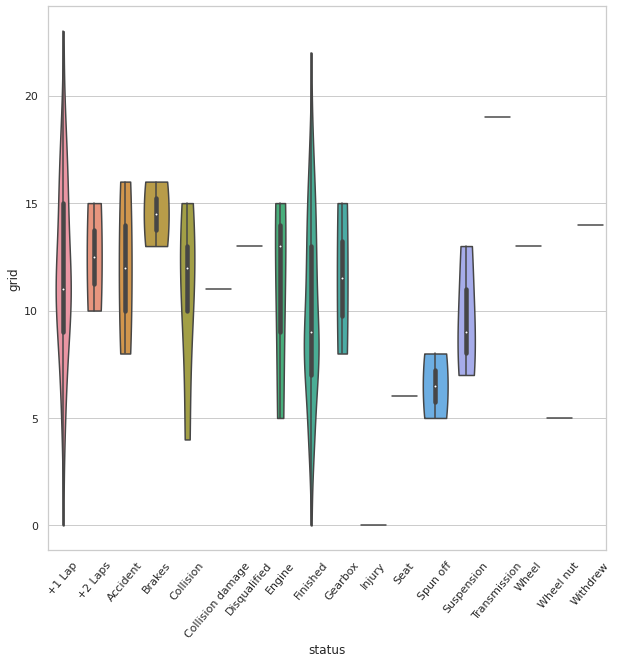

In [ ]:
# Mostramos la relación del estatus con los puntos obtenidos
plt.figure(figsize=(10, 10))
ax = sns.violinplot(data=count_checo_status_equipo, x='status', y='grid', cut=0)
ax.set_xticklabels(ax.get_xticklabels(), rotation=50);

In [ ]:
race_filt=df_dictionary['races']
races_filter_2010=race_filt.loc[pd.DatetimeIndex(race_filt['date']).year>2010]
races_ids=race_filt.loc[pd.DatetimeIndex(race_filt['date']).year>2010]['raceId'].unique()
races_filter_2010=race_filt.loc[pd.DatetimeIndex(race_filt['date']).year>2010]
races_ids=race_filt.loc[pd.DatetimeIndex(race_filt['date']).year>2010]['raceId'].unique()

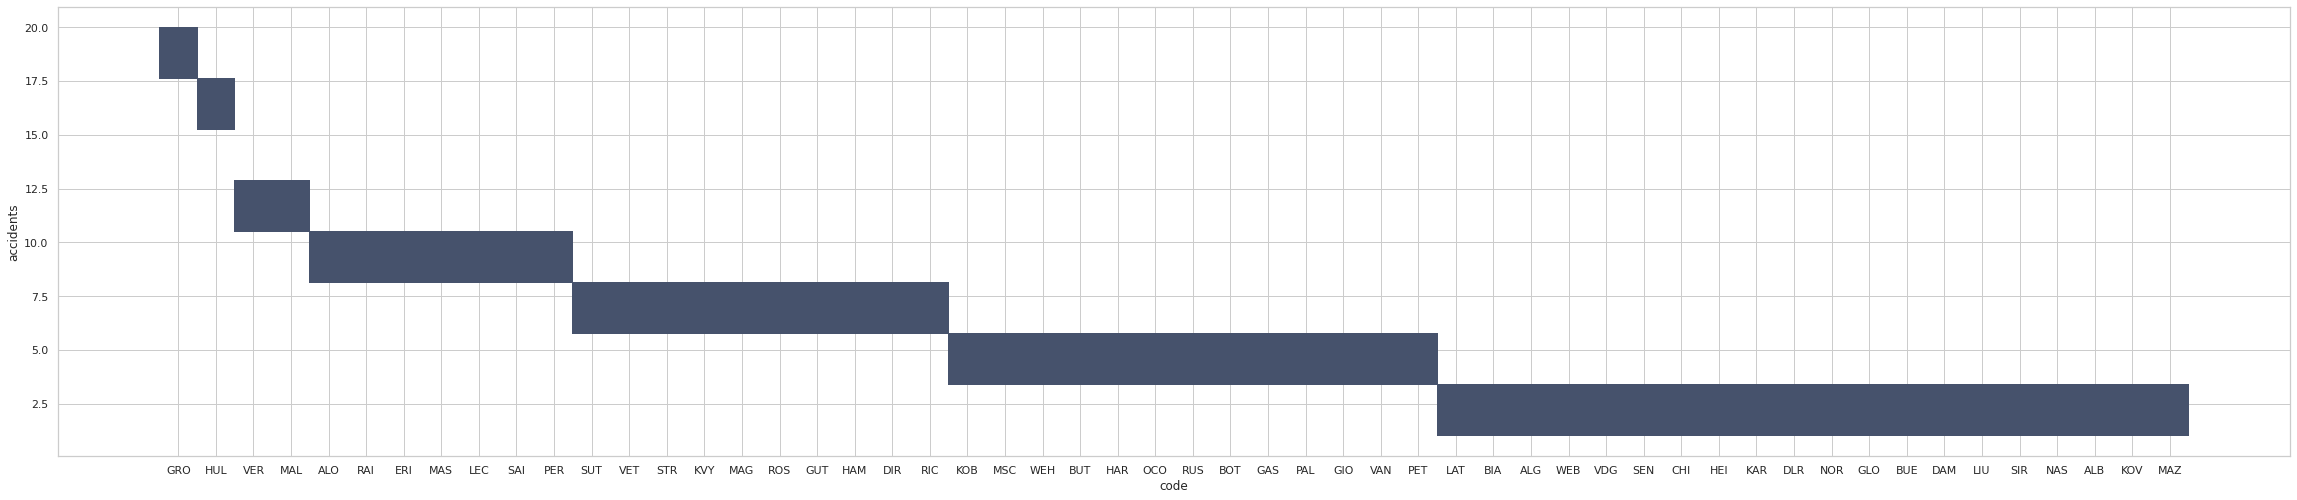

In [ ]:
df_results=df_dictionary['results']
#df_results.loc[]
df_results_filtered_2010 =df_results.loc[df_results['raceId'].isin(races_ids)]
for_drop=[
          'fastestLapSpeed',
          'fastestLapTime',
          'rank',
          'laps',
          'time',
          'fastestLap',
          'milliseconds',
          'points',
          'positionOrder',
          'positionText',
          'constructorId',
          'number',
          'grid',
          'position',
          'resultId',
          'raceId'
          ]
status_id=[
           3,4,130
]


df_results_filtered_2 =df_results_filtered_2010.drop(for_drop, axis=1)
df_results_filtered_2
df_crash=df_results_filtered_2.loc[df_results_filtered_2['statusId'].isin(status_id)]
crashes_filtered =pd.DataFrame(df_crash.groupby('driverId').size())
crashes_filtered_sort=crashes_filtered.reset_index(inplace=False)
crashes_filtered_sort.columns = ['driverId','accidents']
crash_graph=crashes_filtered_sort.sort_values(by='accidents',ascending=False)
crash_graph['driverId'].count()
aux =crash_graph.merge(df_dictionary['drivers'][['driverId','code']],on='driverId')
aux_pop=aux[['code','accidents']]
aux_pop.sort_values(by='accidents',ascending=False)
# df_dictionary['drivers'][['driverId','code']]

plt.rcParams['figure.figsize']= 40,8.27
#sns.histplot(aux_pop,x='code',y='accidents')
aux_pop=aux_pop.reindex()
aux_pop.loc[aux_pop['code']=='VER']
aux_pop.at[35,'accidents'] = 12
aux_pop.loc[aux_pop['code']=='VER']
aux_pop_filt=aux_pop.drop([9])
aux_pop_filt

aux_pop_filt.at[48,'accidents'] = 4
aux_pop_filt=aux_pop_filt.drop([33])

sns.histplot(aux_pop_filt.sort_values(by=['accidents'],ascending=False),x='code',y='accidents')


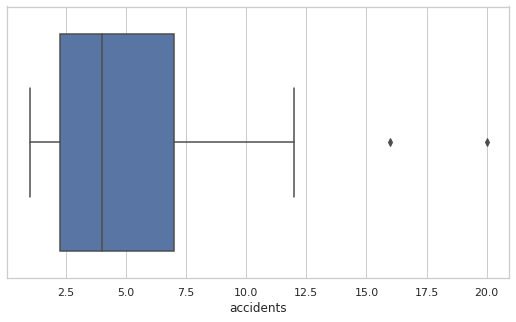

In [ ]:
plt.rcParams['figure.figsize']=9,5
sns.boxplot(x=aux_pop_filt['accidents'])
plt.rcParams['figure.figsize']=6,5

#### 2.2 Comparación de Checo Pérez y el piloto que reemplazó en Red Bull.

Como Checo Pérez acaba de unirse Red Bull este año, no tenemos suficientes datos para realizar una comparación confiable entre él y su compañero de equipo Verstappen. Con lo cual, decidimos comparar al Checo con el piloto que reemplazó en Red Bull, a saber, Alexander Albon. En concreto, nos interesa saber cómo se distribuyen los timepos de vuelta de ambos conductores a lo largo de campeonatos en donde ambos hayan participado. 

In [ ]:
# Insertar código correspondiente
# Checo 815
# Albon 848
tiempos_vueltas = df_dictionary['lap_times']
tiempos_vueltas = tiempos_vueltas.loc[tiempos_vueltas['driverId'].isin([815, 848])]
tiempos_vueltas = tiempos_vueltas.merge(df_dictionary['races'], left_on = 'raceId', right_on = 'raceId')
tiempos_vueltas = tiempos_vueltas[tiempos_vueltas['year'].isin([2019,2020])] #Año a partir del cual tanto Checo como Albon estaban en la F1
tiempo_vueltas = tiempos_vueltas.isna().sum(axis=0) #Quitamos los registros en donde no se ha registrado el timepo en milisegundos
tiempos_vueltas.groupby(['driverId'])[['position', 'milliseconds']].describe() #Comparamos la posición y el timepo de vuelta de Checo y Albon

position                      ... milliseconds                      
            count      mean       std  ...          50%        75%        max
driverId                               ...                                   
815        2048.0  8.998047  4.098208  ...      86573.0  100736.75  1681313.0
848        2239.0  9.039303  4.314934  ...      90360.0  101521.00  1682347.0

[2 rows x 16 columns]

Sin eliminar los datos atípicos vemos que la media del tiempo de vuelta de Checo Pérez es menor que la media de Albon. El problema con analizar las posiciones y los tiempos de vuelta de esta forma es que se están contabilizando las vueltas en donde el piloto entró a los pits o cuando ingresó un *safety car* a la pista. En estas situaciones, el tiempo de vuelta del conductor aumenta drásticamente, no por un mal desempeño, sino porque ha ocurrido un accidento o porque un cambio de llanta es necesario. En este sentido, es más razonable no contabilizar estos tiempos de vuelta porque modifican drásticamente el promedio y la desviación estándar y no reflejan el desempeño real del conductor. Quitando los datos atípicos nos aseguramos de contabilizar únicamente las vueltas en donde ningún imprevisto o entrada a pits tuvo lugar. Por otro lado, puede haber carrera en donde alguno de los dos conductores no estuvo presente y la longitud de la pista puede inclinar la balanza a favor de alguno de los dos conductores. Entonces por un lado quitaremos los datos atípicos y por otro lado no tomaremos en cuenta los *lapTimes* en donde uno de los corredores no tenga registrado un tiempo.

¿Cómo cambiarian la media y la desviación estándar del tiempo de vuelta de Checo y de Albon si quitamos los datos atípicos?

In [ ]:
# Creamos una funcuión que elemine los datos atípicos
def noAtipicos(df,columna):
  iqr = df[columna].quantile(0.75) - df[columna].quantile(0.25)
  filtro_inferior = df[columna] > df[columna].quantile(0.25) - (iqr * 1.5)
  filtro_superior = df[columna] < df[columna].quantile(0.75) + (iqr * 1.5)

  df_filtrado = df[filtro_inferior & filtro_superior]
  print(df_filtrado[columna].describe())
  sns.boxplot(df_filtrado[columna])
  plt.axvline(df_filtrado[columna].mean(), c='y')
  
  return

tiempos_checo = tiempos_vueltas[tiempos_vueltas['driverId'] == 815] # Tiempos de Checo
tiempos_albon = tiempos_vueltas[tiempos_vueltas['driverId'] == 848] # Tiempos de Albon
tiempos_checo = tiempos_checo[tiempos_checo['milliseconds'].notna()] # Quitamos los na
tiempos_albon = tiempos_albon[tiempos_albon['milliseconds'].notna()]
compara_checo_albon = pd.merge(tiempos_checo, tiempos_albon,  how='inner', left_on=['raceId','lap'], right_on = ['raceId','lap']) # Unimos de acuerdo a la misma carrera y mismo número de vuelta
compara_checo_albon = compara_checo_albon[['raceId','lap', 'milliseconds_x', 'milliseconds_y']] # Filtramos solo los datos que nos interesan
tiempos_checo = compara_checo_albon.milliseconds_x # Solo tomaremos en cuenta los timepos de Checo en donde Albon también tiene un tiempo registrado
tiempos_albon = compara_checo_albon.milliseconds_y # Solo tomaremos en cuenta los tiempos de Albon en donde Checo también tiene un tiempo registrado

count      1943.000000
mean      89123.050437
std       14277.927660
min       56789.000000
25%       80367.000000
50%       85821.000000
75%      100270.500000
max      130792.000000
Name: milliseconds_x, dtype: float64


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



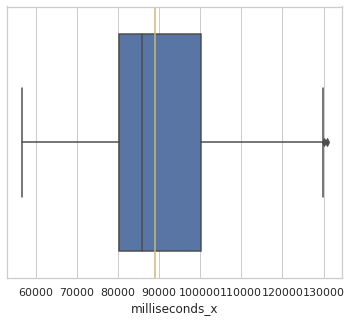

In [ ]:
noAtipicos(compara_checo_albon, 'milliseconds_x')

count      1947.00000
mean      89137.03133
std       14366.87271
min       57056.00000
25%       79974.00000
50%       86008.00000
75%      100219.50000
max      131074.00000
Name: milliseconds_y, dtype: float64


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



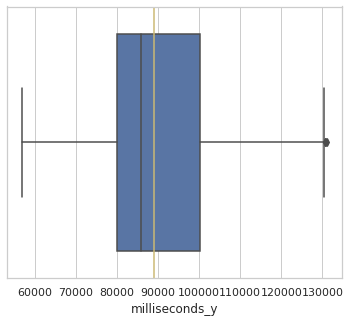

In [ ]:
noAtipicos(compara_checo_albon, 'milliseconds_y')

Ahora sabemos que incluso quitando los datos atípicos Checo Pérez tiene una media de vuelta menor que Alexander Albon. Podemos ir más allá y tomar en cuenta sólo los *lapTimes* donde ambos corredores estaban presentes y después aproximar la distribución muestral del estimador de la media con *bootstrapping*.

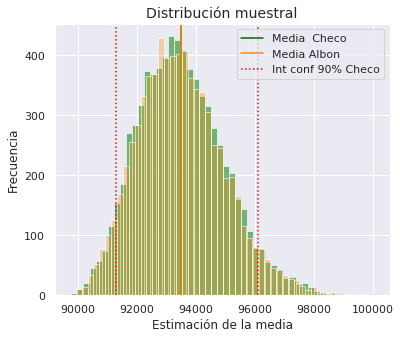

In [ ]:
medias_checo = [] 
medias_albon = []
for i in range(7500): # Generamos 7500 muestras para obtener 7500 estimaciones de la media
  muestra = np.random.choice(tiempos_checo.values, len(tiempos_checo), replace = True) # Muestra aleatoria con reemplazo
  media = muestra.mean()
  medias_checo.append(media)

for i in range(7500): 
  muestra = np.random.choice(tiempos_albon.values, len(tiempos_albon), replace = True) 
  media = muestra.mean()
  medias_albon.append(media)



# Graficamos la distribución muestral del estimador de la media
sns.set(style="darkgrid")
ax = sns.histplot(medias_checo, bins=50, color="forestgreen", alpha=0.6)
ax.set(xlabel='Estimación de la media', ylabel='Frecuencia')
sns.histplot(medias_albon, bins=50, color="darkorange", alpha = 0.3)
plt.title('Distribución muestral', fontsize=14)
plt.axvline(tiempos_checo.mean(), color = 'darkgreen', label = 'Media  Checo') # Dibujamos una linea en la media de Checo
plt.axvline(tiempos_albon.mean(), color = 'darkorange', label = 'Media Albon') # Dibujamos una linea en la media de Albon


#Podriamos incluso hacer un intervalo de confianza para la media de Checo
a = np.quantile(np.array(medias_checo), 0.05)
b = np.quantile(np.array(medias_checo), 0.95)
plt.axvline(a, color = 'red', label = 'Int conf 90% Checo', linestyle = 'dotted') # Dibujamos una linea en la media de Checo
plt.axvline(b, color = 'red', linestyle = 'dotted')

plt.legend()

In [ ]:
print('Media del Checo: ', tiempos_checo.mean())
print('Media del Albon: ', tiempos_albon.mean())

Media del Checo:  93499.8857715431
Media del Albon:  93488.3507014028


In [ ]:
print("Curtosis Checo: ", kurtosis(medias_checo))
print("Asimetría Checo: ",skew(medias_checo))

Curtosis Checo:  0.12382594569777172
Asimetría Checo:  0.4287630683978199


Podemos decir que con un nivel de confianza del 90% el verdadero valor de la media de *lapTimes* de Checo Pérez está en el intervalo: 

In [ ]:
print('[',a,',',b,']')

[ 91276.42136773547 , 96106.10809118237 ]


Aproximar la distribución muestral del estimador de la media de Checo y de Albon por separado no nos da demasiada información. Ahora la media de Checo es mayor que la de Albon, ¿pero realmente estamos seguros de esto? En estricto sentido, no. Nosotros ignoramos cuál es la media *real* de Checo y de Albon porque sólo contamos con una estimación de la verdadera media de ambos conductores. Es decir, estamos asumiendo que existe una distribución de probabilidad subyacente que genera los *lapTimes* y nosotros sólo estamos observando una muestra de esas variables aleatorias para calcular la media. Entonces, a pesar de que la media muestral de Checo sea menor que la de Albon, ¿qué tan verosímil es pensar que la media real de Checo es menor que la media real de Albon? Realizaremos un contraste de hipótesis para responder esta pregunta.
Sean $X$ y $Y$ las variables aleatorias de los *lapTimes* de Checo y Albon respectivamente. Definimos a la variable aleatoria $Z = X - Y$ cuya media $\mu$ es desconocida. Relizaremos el contraste de hipótesis $H_{nul}: \mu = 0$ vs $H_{alt}: \mu \neq 0$ con un nivel de significancia $\alpha = 0.1$.

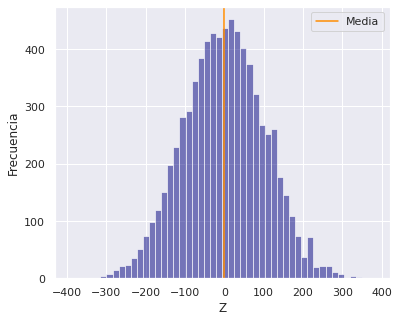

In [ ]:
# Restamos los timepos de Albon a los timepos de Checo
z = compara_checo_albon.milliseconds_x - compara_checo_albon.milliseconds_y
z_centrada = z.values - np.mean(z.values) # Le restamos la media para que nuestros datos tengan media 0, puesto que esa es nuestra hipótesis nula

# Obtenemos nuestras muestras bootstrap
z_medias = []
for i in range(7500): 
  muestra = np.random.choice(z_centrada, len(z_centrada), replace = True)
  media = muestra.mean()
  z_medias.append(media)

# Graficamos la distribución muestral del estimador de la media
sns.set(style="darkgrid")
ax = sns.histplot(z_medias, bins=50, color="navy", alpha=0.5)
ax.set(xlabel='Z', ylabel='Frecuencia')
plt.axvline(0, color = 'darkorange', label = 'Media')
plt.legend()

Incluso antes de hacer el contraste de hipótesis podríamos decir que es muy probable que la hipótesis nula no sea rechazada puesto que la diferencia entre las medias de Checo y Albon es demasiado baja.

In [ ]:
print("Media de X-Y: ", np.mean(z.values))

Media de X-Y:  11.535070140280562


¿Cuál es entonces la probabilidad bajo $H_{nul}$ de obtener una estimación que diste de la verdadera media más de 11.53?

In [ ]:
contador = 0
for z in z_medias:
  if z <= 11-53 or z >= 11.53:
    contador = contador + 1
p_value = contador/len(z_medias)
print(p_value)

0.8001333333333334


Con lo cual, la hipótesis nula está lejos de ser rechazada. Esto quiere decir que para el nivel de significancia que hemos elegido, no podemos afirmar que Checo sea mejor que Albon y viceversa. Una variable adiconal a considerar es que en el lapso de tiempo que estos dos conductores estan siendo comparados competían con diferentes autos. La cuestión es que no tenemos la información ni contamos con un método que controle por esta variable. Aun así, dada la información que tenemos sólo podemos afirmar que no hay evidencia concluyente que nos demuestro que un piloto es mejor que el otro.

#### 2.3 Relación entre la posición final de la carrera y la posición de la clasifiación final del piloto

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



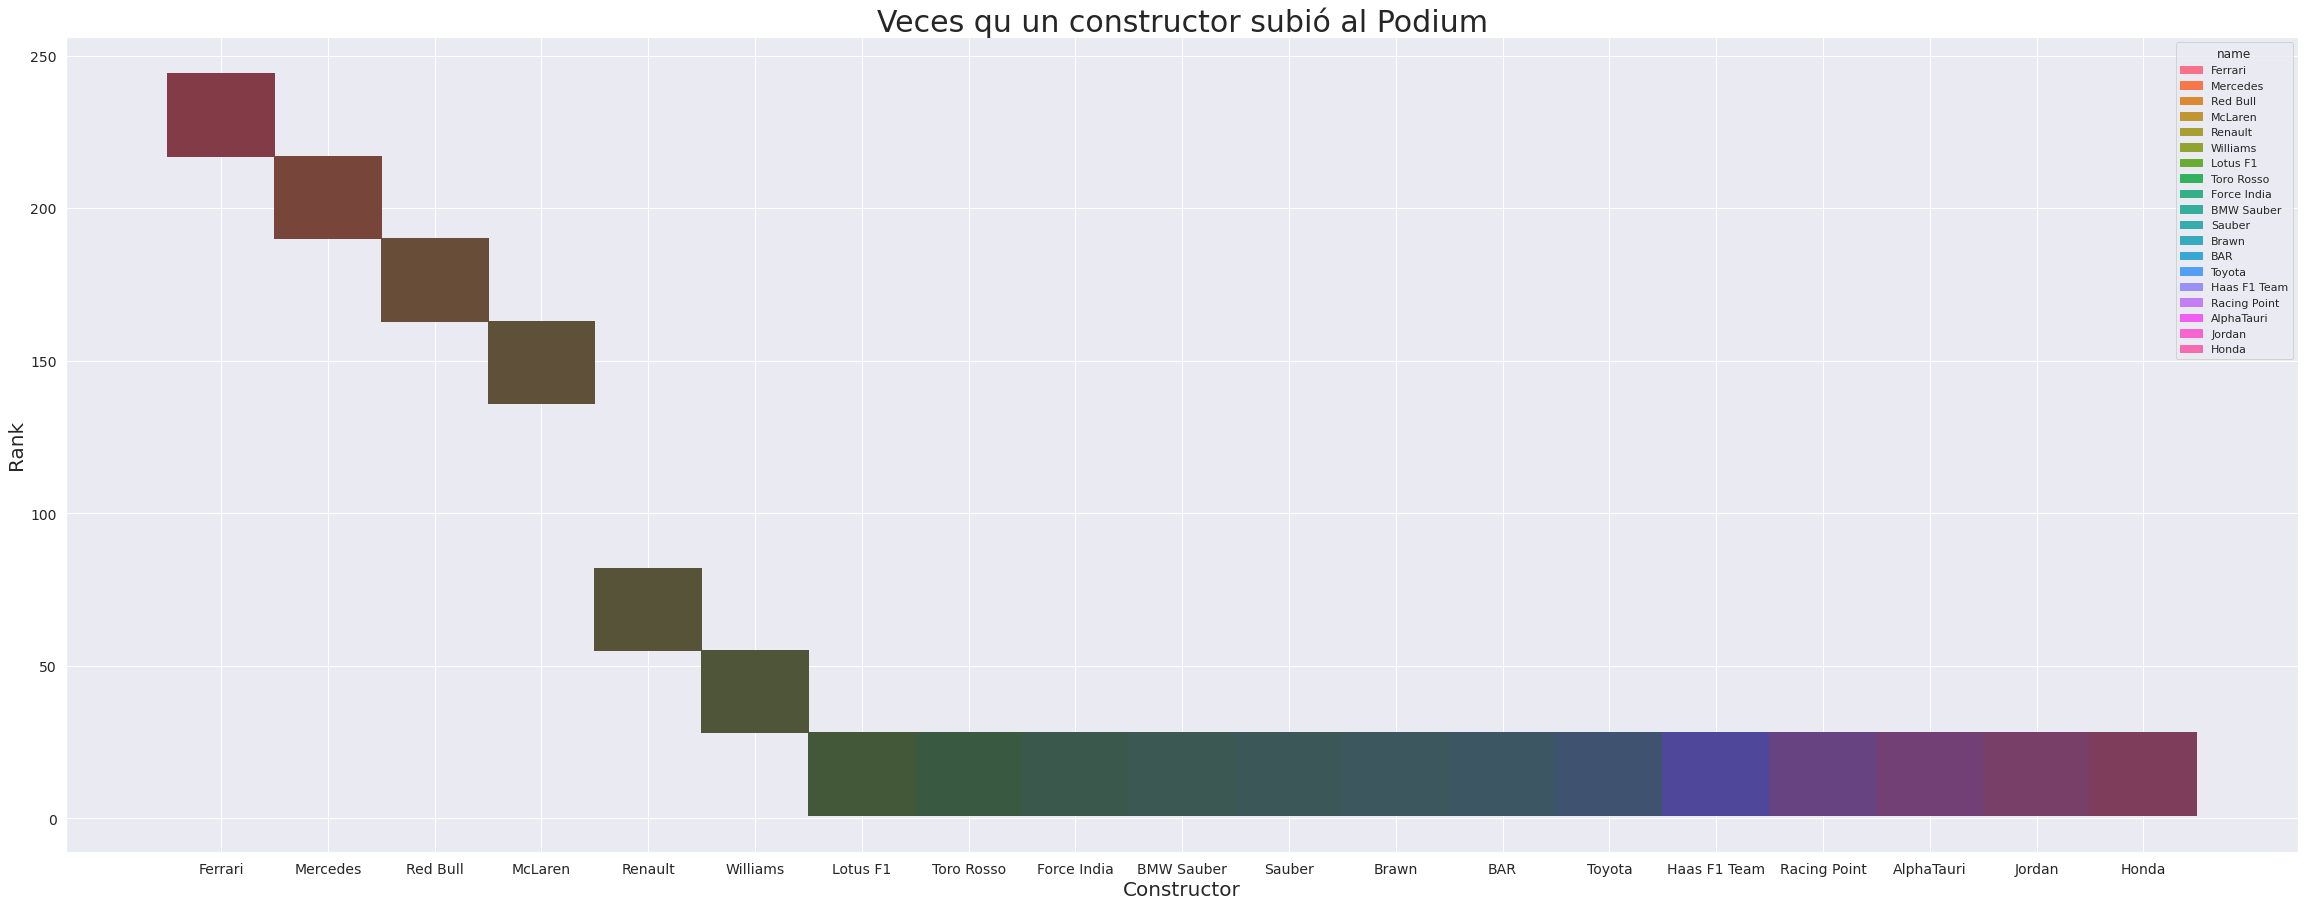

In [ ]:
plt.rcParams['figure.figsize']= 40,15
plt.title('Veces qu un constructor subió al Podium', fontsize=30)
plt.xlabel('Constructor', fontsize=20)
plt.ylabel('Rank', fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
results=df_dictionary['results']
results_clean=results.loc[results['rank'] != '\\N']
results_clean['rank'] = pd.to_numeric(results_clean['rank'])
result_clean_less_10= results_clean.loc[results_clean['rank'] < 4  ]
result_clean_less_10 = result_clean_less_10.loc[result_clean_less_10['rank'] != 0 ]
result_clean_less_10=result_clean_less_10[['constructorId','rank']]
result_clean_less_10=result_clean_less_10.groupby('constructorId').count()
result_clean_less_10=result_clean_less_10.merge(df_dictionary['constructors'][['constructorId','name']],on='constructorId').sort_values(by=['rank'],ascending=False)
sns.histplot(data=result_clean_less_10,x='name',y='rank',hue='name')
plt.rcParams['figure.figsize']=6,5

##### Filtrado y procesamiento de datos

Para esta sección se obtienen los datos de las carreras del 2015 al 2020 con los pilotos Sergio Perez, Max Verstappen, Alex Albon y Lewis Hamilton.

Aquí se evaluará las correlaciones entre velocidades de las clasificatorias, Grand Prix, y las posiciones iniciales y finales.

In [ ]:
# Merge de results, qualifying y races
# Filtrado por años y conductores

fastest_time = df_dictionary['results'].merge(df_dictionary['qualifying'], left_on = ['raceId','driverId'], right_on = ['raceId','driverId'])
fastest_time = fastest_time.merge(df_dictionary['races'], left_on = 'raceId', right_on = 'raceId')
fastest_time = fastest_time[(fastest_time['year'].isin([2015,2016,2017,2018,2019,2020])) & (fastest_time['driverId'].isin([1,830,815,848]))]
fastest_time.head(5)

,resultId,raceId,driverId,constructorId_x,number_x,grid,position_x,positionText,positionOrder,points,laps,time_x,milliseconds,fastestLap,rank,fastestLapTime,fastestLapSpeed,statusId,qualifyId,constructorId_y,number_y,position_y,q1,q2,q3,year,round,circuitId,name,date,time_y,url
6287,22538,926,1,131,44,1,1,1,1,25.0,58,1:31:54.067,5514067,50,1,1:30.945,209.915,1,6309,131,44,1,1:28.586,1:26.894,1:26.327,2015,1,1,Australian Grand Prix,2015-03-15,05:00:00,http://en.wikipedia.org/wiki/2015_Australian_G...
6296,22547,926,815,10,11,14,10,10,10,1.0,57,\N,\N,46,7,1:31.959,207.601,11,6323,10,11,15,1:29.990,1:29.209,\N,2015,1,1,Australian Grand Prix,2015-03-15,05:00:00,http://en.wikipedia.org/wiki/2015_Australian_G...
6299,22550,926,830,5,33,11,\N,R,13,0.0,32,\N,\N,30,13,1:34.295,202.458,5,6320,5,33,12,1:29.248,1:28.868,\N,2015,1,1,Australian Grand Prix,2015-03-15,05:00:00,http://en.wikipedia.org/wiki/2015_Australian_G...
6306,22557,927,1,131,44,1,2,2,2,18.0,56,+8.569,6074362,45,2,1:43.125,193.501,1,6327,131,44,1,1:39.269,1:41.517,1:49.834,2015,2,2,Malaysian Grand Prix,2015-03-29,07:00:00,http://en.wikipedia.org/wiki/2015_Malaysian_Gr...
6311,22562,927,830,5,33,6,7,7,7,6.0,56,+1:37.762,6163555,42,9,1:44.579,190.810,1,6332,5,33,6,1:40.793,1:41.430,1:51.981,2015,2,2,Malaysian Grand Prix,2015-03-29,07:00:00,http://en.wikipedia.org/wiki/2015_Malaysian_Gr...


In [ ]:
# Selección de columnas
cut_fastest = fastest_time[['raceId','position_x','driverId','q1','q2','q3','grid','fastestLapTime']]
#cut_fastest

In [ ]:
# Cambiar strings '\N' por un valor Not a Number
cut_fastest.replace(r'\N', np.nan, inplace=True)
#cut_fastest.isna().sum(axis=0)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4389: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
# Borrado de registros donde haya nan

clean_fastest =cut_fastest.dropna(subset=['q2','q3','fastestLapTime','grid','position_x'])
#print(clean_fastest.isna().sum(axis=0))
#print(clean_fastest.shape)
clean_fastest.head(5)

,raceId,position_x,driverId,q1,q2,q3,grid,fastestLapTime
6287,926,1,1,1:28.586,1:26.894,1:26.327,1,1:30.945
6306,927,2,1,1:39.269,1:41.517,1:49.834,1,1:43.125
6311,927,7,830,1:40.793,1:41.430,1:51.981,6,1:44.579
6324,928,1,1,1:38.285,1:36.423,1:35.782,1,1:42.208
6344,929,1,1,1:33.928,1:32.669,1:32.571,1,1:37.857


Se observa que los tiempos por vuelta está en un formato de tiempo que no puede ser procesado. Por ello, se hace una función para transformar a milisegundos

In [ ]:
def millisecondsFunc(datos):
  m = pd.to_datetime(datos, format='%M:%S.%f').dt.minute
  s = pd.to_datetime(datos, format='%M:%S.%f').dt.second
  ms = pd.to_datetime(datos, format='%M:%S.%f').dt.microsecond

  millis = (60000 * m + 1000 * s + ms * .001)
  return millis

clean_fastest[['q1','q2','q3','fastestLapTime']] = clean_fastest[['q1','q2','q3','fastestLapTime']].apply(millisecondsFunc)
clean_fastest.head(5)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3069: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,raceId,position_x,driverId,q1,q2,q3,grid,fastestLapTime
6287,926,1,1,88586.0,86894.0,86327.0,1,90945.0
6306,927,2,1,99269.0,101517.0,109834.0,1,103125.0
6311,927,7,830,100793.0,101430.0,111981.0,6,104579.0
6324,928,1,1,98285.0,96423.0,95782.0,1,102208.0
6344,929,1,1,93928.0,92669.0,92571.0,1,97857.0


##### Correlaciones entre variables
Si lo que queremos hacer es tratar de estimar la posición final del conductor, necesitamos ver qué variables numéricas están correlacionadas para saber cuál es su capacidad de predicción y poder utilizarlas en nuestra regresión lineal.

A continuación se crean una serie de diagramas tipo heatmap, pairplots y binning hexagonal para evaluar si existe alguna relación entre la posición final e inicial del piloto y las velocidades en esa carrera

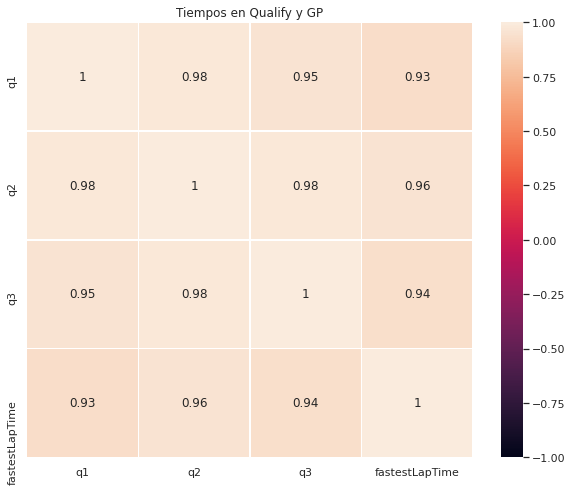

In [ ]:
plt.figure(figsize=(10, 8))
ax = sns.heatmap(clean_fastest[['q1','q2','q3','fastestLapTime']].corr(), vmin=-1, vmax=1, annot=True, linewidths=.5)
ax.set_title('Tiempos en Qualify y GP');

Se observa que existe una fuerte correlación en las velocidades de clasificaciones y la vuelta más rápida del piloto en la carrera.

Ahora se requiere evaluar la relación entre esas velocidades y el número de veces que un piloto entra a los pits y en qué vuelta lo hace.

In [ ]:
clean_fastest = clean_fastest.merge(df_dictionary['drivers'], left_on = 'driverId', right_on = 'driverId')
#clean_fastest

In [ ]:
clean_fastest['position_x'] = pd.to_numeric(clean_fastest['position_x'])
clean_fastest['position_x','grid'] = clean_fastest[['position_x','grid']].astype(int).dtypes
#clean_fastest.dtypes

In [ ]:
pits_max = df_dictionary['pit_stops'].merge(df_dictionary['races'], left_on = 'raceId', right_on = 'raceId')
pits_max = pits_max[(pits_max['year'].isin([2015,2016,2017,2018,2019,2020])) & (pits_max['driverId'].isin([1,830,815,848]))]
# Checo 815
#data_map = data_map.loc[data_map.groupby('circuitId')['points'].agg(pd.Series.idxmax)]
#pit_grouped = pits_max.groupby(['driverId','raceId'])[['milliseconds','lap']].max()
pit_grouped = pits_max.loc[pits_max.groupby(['driverId','raceId'])['milliseconds'].agg(pd.Series.idxmax)]

#pit_max_stops = pits_max.groupby(['driverId','raceId'])[['stop','milliseconds','lap']].max()
pit_max_stops = pits_max.loc[pits_max.groupby(['driverId','raceId'])['stop'].agg(pd.Series.idxmax)]

In [ ]:
dfTest = clean_fastest
dfTest = dfTest.merge(pit_grouped, left_on = ['raceId','driverId'], right_on = ['raceId','driverId'])
#dfTest

In [ ]:
dfTest_stops = clean_fastest
dfTest_stops = dfTest_stops.merge(pit_max_stops, left_on = ['raceId','driverId'], right_on = ['raceId','driverId'])
#dfTest_stops

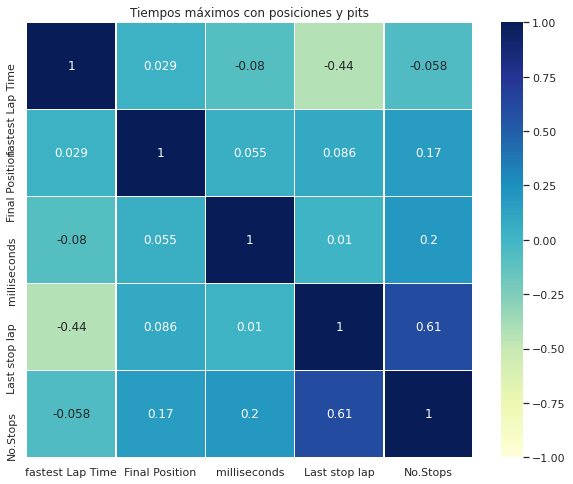

In [ ]:
plt.figure(figsize=(10, 8))
ax = sns.heatmap(dfTest_stops[['fastestLapTime','position_x','milliseconds','lap','stop']].corr(), vmin=-1, vmax=1, annot=True, linewidths=.5,cmap="YlGnBu")
ax.set_xticklabels(['fastest Lap Time','Final Position','milliseconds','Last stop lap','No.Stops'])
ax.set_yticklabels(['fastest Lap Time','Final Position','milliseconds','Last stop lap','No.Stops'])
ax.set_title('Tiempos máximos con posiciones y pits');

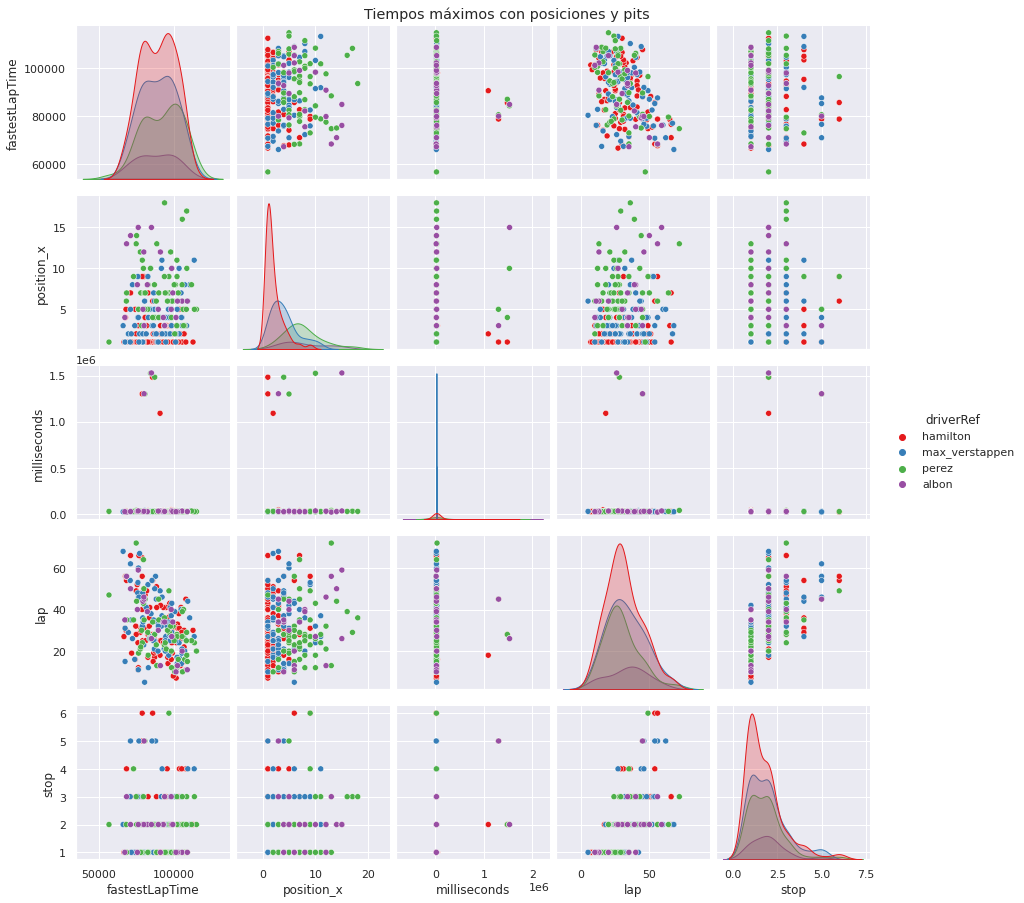

In [ ]:
g = sns.pairplot(dfTest_stops[['driverRef','fastestLapTime','position_x','milliseconds','lap','stop']], hue='driverRef', palette="Set1")
g.fig.suptitle("Tiempos máximos con posiciones y pits", y=1.005);

La correlación entre la variable **Final Position** y las demás es muy baja. Es posible entonces que utilizar estas variables en una regresión lineal no sea razonable. Por otro lado, hay algunas tendencias interesantes. Primero, hay una correlación de -0.44 entre *Last Stop Lap* y *fastest Time Lap*. Esto quiere decir que mientras más tarde el conductor haga el último cambio de llantas es más probable que tenga el tiempo más rápido de vuelta. Segundo, hay una correlación de 0.61 entre *Last Stop Lap* y *No. Stops*. Esta correlación nos indica que mientras más tarde el conductor haga el último cambio de llantas la estrategia del equipo fue correr con llantas suaves o extra suaves, pues esto implica un mayor número de paradas en los pits. Estas observaciones pueden ser de gran utilidad en la posterior implementación de un modelo predictivo. Por lo pronto, para fines del objetivo de esta sección, no logramos obtener más variables que estén fuertemente correlacionadas con la posición final del conductor.

Repetimos este análisis de correlaciones para distintas combinaciones de variables numéricas y ver si alguna nos sirve para ajustar el modelo de regresión.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



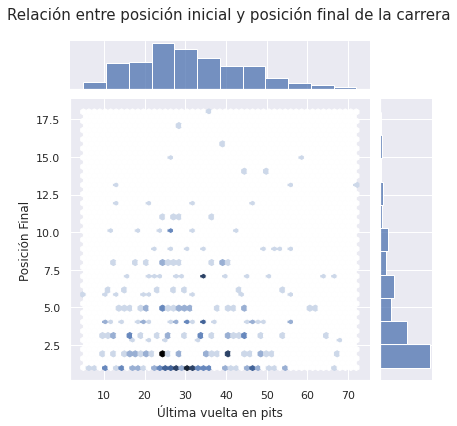

In [ ]:
g = sns.jointplot('lap', 'position_x', data=dfTest_stops, kind='hex', ratio=5, joint_kws={'gridsize': 50})
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('Relación entre posición inicial y posición final de la carrera', fontsize=15)
g.set_axis_labels(xlabel='Última vuelta en pits',ylabel='Posición Final')

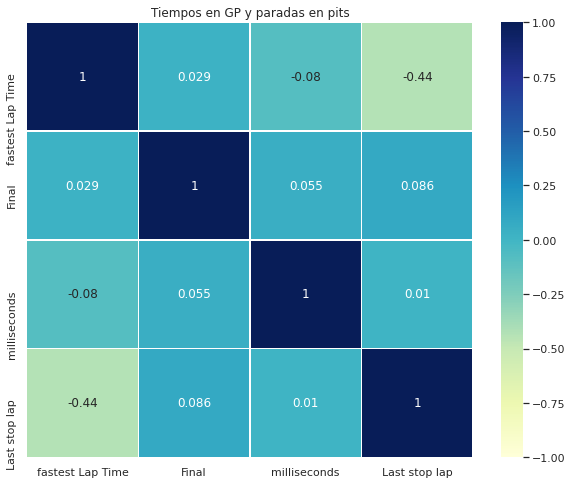

In [ ]:
plt.figure(figsize=(10, 8))
ax = sns.heatmap(dfTest_stops[['fastestLapTime','position_x','milliseconds','lap']].corr(), vmin=-1, vmax=1, annot=True, linewidths=.5,cmap="YlGnBu")
ax.set_xticklabels(['fastest Lap Time','Final','milliseconds','Last stop lap'])
ax.set_yticklabels(['fastest Lap Time','Final','milliseconds','Last stop lap'])
ax.set_title('Tiempos en GP y paradas en pits');

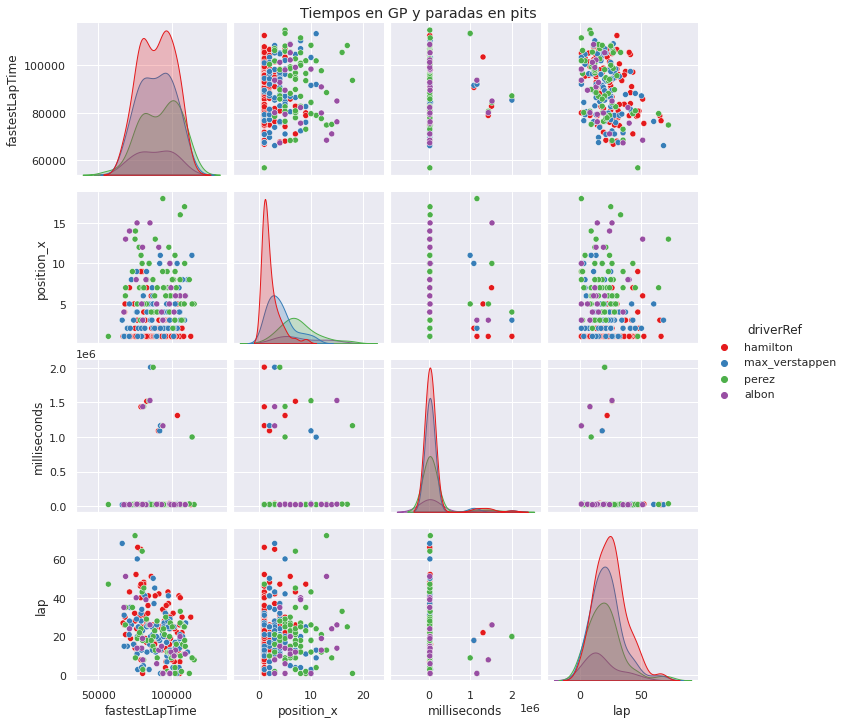

In [ ]:
g = sns.pairplot(dfTest[['driverRef','fastestLapTime','position_x','milliseconds','lap']], hue='driverRef', palette="Set1")
g.fig.suptitle("Tiempos en GP y paradas en pits", y=1.005);

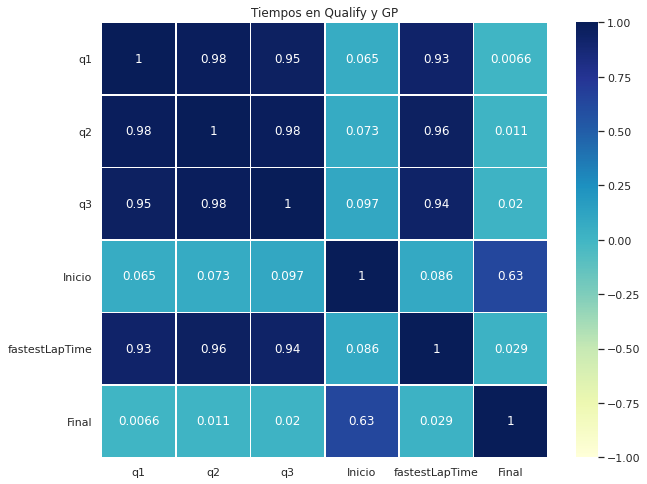

In [ ]:
plt.figure(figsize=(10, 8))
ax = sns.heatmap(clean_fastest[['q1','q2','q3','grid','fastestLapTime','position_x']].corr(), vmin=-1, vmax=1, annot=True, linewidths=.5,cmap="YlGnBu")
ax.set_xticklabels(['q1','q2','q3','Inicio','fastestLapTime','Final'])
ax.set_yticklabels(['q1','q2','q3','Inicio','fastestLapTime','Final'])
ax.set_title('Tiempos en Qualify y GP');

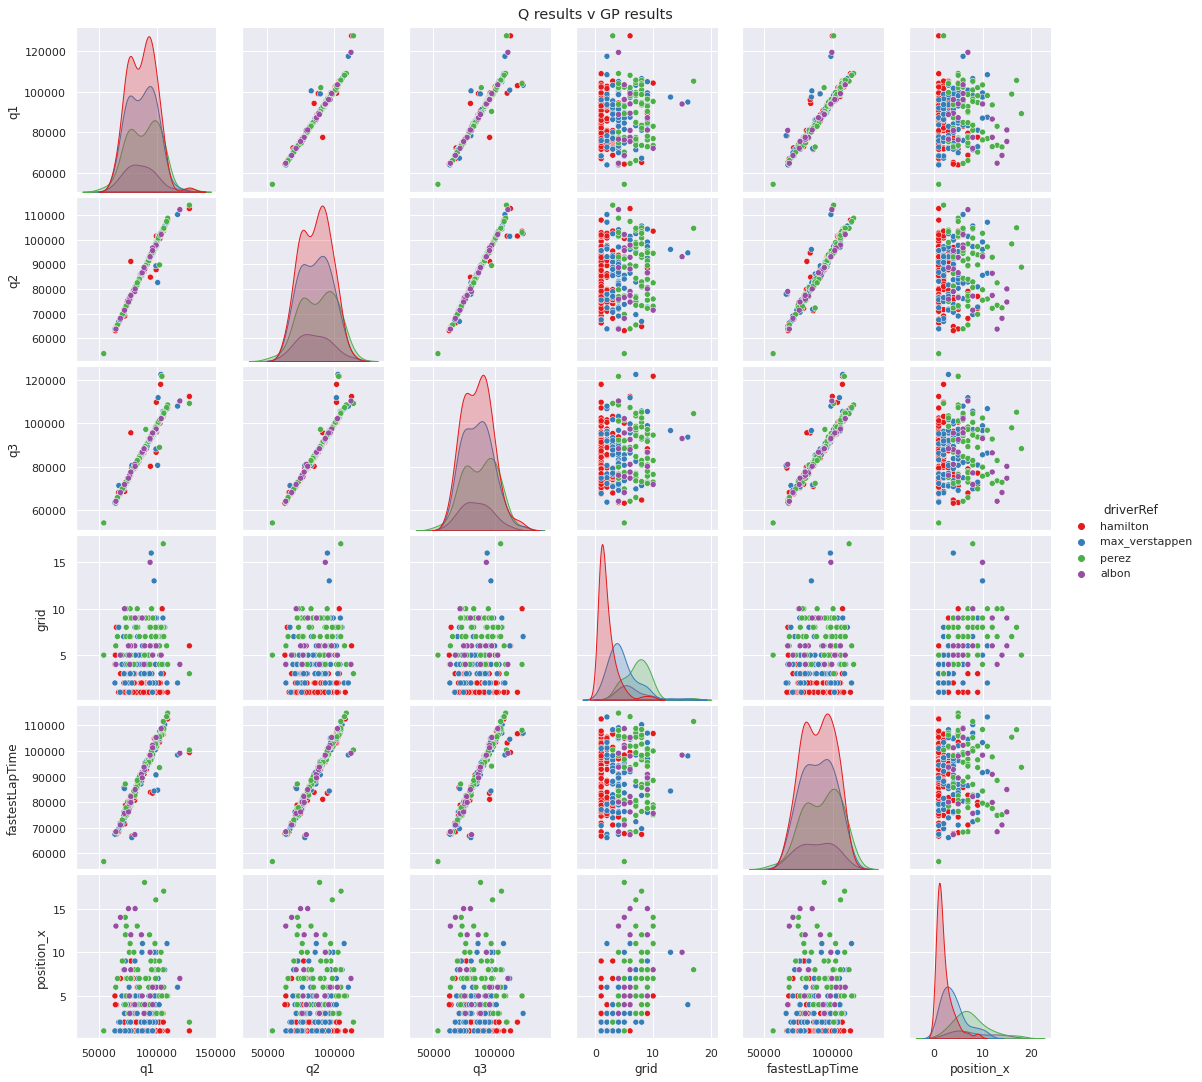

In [ ]:
g = sns.pairplot(clean_fastest[['driverRef','q1','q2','q3','grid','fastestLapTime','position_x']], hue='driverRef', palette="Set1")
g.fig.suptitle("Q results v GP results", y=1.005);

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



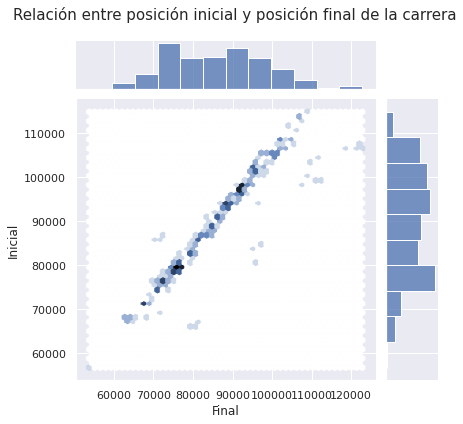

In [ ]:
g = sns.jointplot('q3', 'fastestLapTime', data=clean_fastest, kind='hex', ratio=5, joint_kws={'gridsize': 50})
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('Relación entre posición inicial y posición final de la carrera', fontsize=15)
g.set_axis_labels(xlabel='Final',ylabel='Inicial')

Como podemos observar, además de la posición en la clasifiación, no hay otras variables numéricas fuertemente correlacionadas con lo que queremos predecir. Aún así, esto no quiere decir que nos conformaremos con una regresión lineal simple, sino que utilizaremos la misma variable de distintas formas para ajustar una regresión múltiple como se muestra con detalle a continuación.

##### Ajuste de regresión lineal y algoritmo de validación cruzada

Buscamos implementar un modelos de regresió lineal para predecir la posición final de un conductor en la carrera. El problema al que nos enfrentamos es que no tenemos demasiadas variables numéricas que podamos utilizar en nuestra regresión para nuestros fines predictivos. Quizá la variable más razonable a considerar es la posición del conductor en la clasifiación previa a la carrera, pero más allá de esta variable no consideramos que haya otras variables numéricas que tengan un poder predictivo considerables o que no estén fuertemente correlacionadas con la variable de la posición en la clasifiación. Entonces primero vamos a ajustar un modelo de regresión lineal simple y luego veremos si hay alguna forma de crear un modelo de regresión lineal múltiple.

In [ ]:
posicion_correlacion = pd.merge(df_dictionary['results'], df_dictionary['qualifying'],  how='inner', left_on=['raceId','driverId'], right_on = ['raceId','driverId'])
posicion_correlacion = posicion_correlacion[['position_y','positionOrder']]
posicion_correlacion.columns = ['QualifyPosition', 'RacePosition']
posicion_correlacion

,QualifyPosition,RacePosition
0,1,1
1,5,2
2,7,3
3,12,4
4,3,5
...,...,...
8749,11,16
8750,19,17
8751,18,18
8752,20,19


La correlación de Pearson entre la posicón de clasificación y la posición final de la carrera es de:  0.5642021228735716


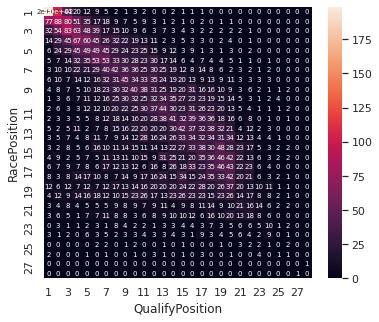

In [ ]:
tabla = pd.crosstab(posicion_correlacion.RacePosition,posicion_correlacion.QualifyPosition, margins = False)
sns.heatmap(tabla, annot=True, annot_kws={"size": 7})
print("La correlación de Pearson entre la posicón de clasificación y la posición final de la carrera es de: ",
      posicion_correlacion['QualifyPosition'].corr(posicion_correlacion['RacePosition']))

Podemos observar que sí existe una correlación entre la posición en la clasifiación previa a la carrera y la posición final en la carrera. Resulta entonces razonable tratar de ajustar un modelo de regresión lineal simple con la posición en la clasificación como variable explicativa.

In [ ]:
variables_explicativas = posicion_correlacion['QualifyPosition'].to_frame()
variables_explicativas.columns = ['X1'] # Cambié el nombre de la columna porque será útil posteriormente
lr = LinearRegression()
lr.fit(variables_explicativas, posicion_correlacion['RacePosition']) # Ajustamos el modelo lineal
position_predict = lr.predict(variables_explicativas) # Predecimos la posición en la carrera a partir de la posición en la clasifiación
posicion_correlacion['Prediction'] = position_predict # Agregamos nuestras predicciones a la tabla
posicion_correlacion

,QualifyPosition,RacePosition,Prediction
0,1,1,5.509276
1,5,2,7.771432
2,7,3,8.902510
3,12,4,11.730206
4,3,5,6.640354
...,...,...,...
8749,11,16,11.164667
8750,19,17,15.688980
8751,18,18,15.123441
8752,20,19,16.254519


In [ ]:
sum((posicion_correlacion.RacePosition - posicion_correlacion.Prediction)**2) # Calculamos la suma del cuadrado de los errores de nuestras predicciones

241309.51598884372

Basta con observar la primera predicción para darnos cuenta de que nuestro modelo de regresión lineal simple es bastante mediocre para predecir la posición final del piloto en la carrera. Por ejemplo, nuestro modelo estima que si un conductor se clasifica en primer lugar terminará en quinta o sexta posición. Quienes conocemos este deporte sabemos que eso no parece ser una buena estimación porque la mayoría de las veces esto no sucede. ¿Podemos mejorar nuestro modelo? Ya dijimos anteriormente que nuestra base de datos no tiene muchas variables numéricas que tengan poder predictivo en este contexto, pero podemos aprovechar el poder predictivo de la variable que ya hemos elegido, a saber, la posición en la clasificación, de una manera distinta. Podriamos tratar de ajustar un modelo de regresión, ya no simple, sino múltiple. ¿Cómo es posible hacer esto si sólo contamos con una variable explicativa? Podríamos crear una nueva variable que sea el cuadrado de la variable explicativa que ya tenemos. Esto quizá aumente la precisión de las predicciones de nuestro modelo puesto que ahora en lugar de ajustar una linea recta a los datos estamos ajustando el polinomio de segundo grado que minimiza la suma del cuadrado de los errores. Podríamos ir incluso más allá y tratar de ajustar un polinomio de grado $n$.

In [ ]:
variables_explicativas['X2'] = posicion_correlacion['QualifyPosition']**2
print(variables_explicativas)

      X1   X2
0      1    1
1      5   25
2      7   49
3     12  144
4      3    9
...   ..  ...
8749  11  121
8750  19  361
8751  18  324
8752  20  400
8753  15  225

[8754 rows x 2 columns]


In [ ]:
lr = LinearRegression()
lr.fit(variables_explicativas, posicion_correlacion['RacePosition']) # Ajustamos el modelo lineal
position_predict = lr.predict(variables_explicativas) # Predecimos la posición en la carrera a partir de la posición en la clasifiación
posicion_correlacion['Prediction'] = position_predict # Agregamos nuestras predicciones a la tabla
posicion_correlacion

,QualifyPosition,RacePosition,Prediction
0,1,1,4.787674
1,5,2,7.739882
2,7,3,9.095519
3,12,4,12.133246
4,3,5,6.303934
...,...,...,...
8749,11,16,11.565856
8750,19,17,15.542789
8751,18,18,15.115945
8752,20,19,15.949555


In [ ]:
sum((posicion_correlacion.RacePosition - posicion_correlacion.Prediction)**2) # Calculamos la suma del cuadrado de los errores de nuestras predicciones

240001.52389944677

La suma del cuadrado de los errores de nuestro primer modelo es de $241309.51598884372$, mientras que en nuestro segundo modelo es de $240001.52389944677$. Esto quiere decir que nuestro segundo modelo tiene mayor presición. De hecho, siempre que aumentemos en uno el grado del polinomio que estamos ajustando tendremos predicciones que son, al menos, tan buenas como las anteriores. Esto se debe a que la familia de polinomios $p_{1}(x) = \beta_{0} + \beta_{1}x + ... + \beta_{n}x^{n-1} + \beta_{n}x^n$ contiene en su totalidad a los polinomio de la forma $p_{2}(x) = \beta_{0} + \beta_{1}x + ... + \beta_{n}x^{n-1}$ pues bastaría asignar a $\beta_{n}=0$ en $p_{1}$ para que ambos conjuntos de polinomios coincidieran. Ahora ajustemos un polinomio de grado tres y veamos qué pasa.

In [ ]:
variables_explicativas['X3'] = posicion_correlacion['QualifyPosition']**3
print(variables_explicativas)

      X1   X2    X3
0      1    1     1
1      5   25   125
2      7   49   343
3     12  144  1728
4      3    9    27
...   ..  ...   ...
8749  11  121  1331
8750  19  361  6859
8751  18  324  5832
8752  20  400  8000
8753  15  225  3375

[8754 rows x 3 columns]


In [ ]:
lr = LinearRegression()
lr.fit(variables_explicativas, posicion_correlacion['RacePosition']) # Ajustamos el modelo lineal
position_predict = lr.predict(variables_explicativas) # Predecimos la posición en la carrera a partir de la posición en la clasifiación
posicion_correlacion['Prediction'] = position_predict # Agregamos nuestras predicciones a la tabla
posicion_correlacion

,QualifyPosition,RacePosition,Prediction
0,1,1,4.284861
1,5,2,7.961079
2,7,3,9.384995
3,12,4,12.145124
4,3,5,6.278007
...,...,...,...
8749,11,16,11.659029
8750,19,17,15.337604
8751,18,18,14.859502
8752,20,19,15.840022


In [ ]:
sum((posicion_correlacion.RacePosition - posicion_correlacion.Prediction)**2) # Calculamos la suma del cuadrado de los errores de nuestras predicciones

239385.5715207589

Como habíamos ya explicado anteriormente, se cumple que agregar un grado al polinomio nos da mayor precisión en nuestra predicción. ¿Por qué no seguir aumentando el grado del polinomio, por ejemplo, un polinomio de grado 20 para seguir aumentando la precisión de nuestras predicciones? Porque estaríamos corriendo el riesgo de sobreentrenar nuestro modelo, es decir, crearíamos un modelo que se ajusta tan bien a los datos de entrenamiento que se vuelve malo prediciendo para datos que no formaban parte del entrenamiento. Debe entonces haber un grado de polinomio óptimo que no sobreentrene y que nos dé la mayor capacidad de generalización. Trataremos de encontrar el grado del polinomio óptimo a través de **leave one out cross validation**. 

In [ ]:
# df.sample(frac=1)
def cross_validate(X): # X es un dataframe donde la última columna tiene la variable a predecir y el resto las variables explicativas
  X = X.sample(frac=1).reset_index(drop=True) # Revolvemos los datos
  errores = []
  for i in range(len(X)):
    testing = X.iloc[i:i+1] # Seleccionamos el bloque de prueba
    training = X[~X.index.isin(testing.index)] # Seleccionamos el bloque de entrenamiento
    lr = LinearRegression() # Inicializa la regresión
    lr.fit(training.iloc[:,:-1], training.iloc[:,-1:]) # Ajusta el modelo a los datos de entrenamiento
    predictions = lr.predict(testing.iloc[:,:-1]) # Aplica la regresión a los datos de prueba
    errores.append(sum((testing.iloc[:,-1:].values - predictions)**2)) # Almacena la suma del cuadrado de los errores del modelo en una lista

  return np.mean(errores)

Para llamar a la función ```cross_vaidate``` vamos a crear cinco dtaframes cada una de ellas con una cantidad distinta de variables explicativas. La más simple será aquella que sólo tiene la posición en la clasificación. La última tabla será aquella que tiene a la variable de posición en clasificación elvada al cuadrado, al cubo, a la cuarta y a la quinta potencia.

In [ ]:
posicion_correlacion = pd.merge(df_dictionary['results'], df_dictionary['qualifying'],  how='inner', left_on=['raceId','driverId'], right_on = ['raceId','driverId'])
posicion_correlacion = posicion_correlacion[['position_y','positionOrder']]
posicion_correlacion.columns = ['QualifyPosition', 'RacePosition']

aux = posicion_correlacion.RacePosition
del posicion_correlacion['RacePosition']
posicion_correlacion.columns = ['X1']
posicion_correlacion['X2'] = posicion_correlacion['X1']**2
posicion_correlacion['X3'] = posicion_correlacion['X1']**3
posicion_correlacion['X4'] = posicion_correlacion['X1']**4
posicion_correlacion['X5'] = posicion_correlacion['X1']**5

tablas_explicativas = []
for i in range(0,5):
  tabla = posicion_correlacion.iloc[:,0:i+1]
  tabla['Y'] = aux
  tablas_explicativas.append(tabla)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Ahora sólo resta aplicar la función ```cross_validate``` a cada una de las tablas contenidas en ```tablas_explicativas``` para saber cuál modelo tiene mayor capacidad de generalización.

In [ ]:
print("Promedio de error cuadrado para polinomio de grado ", 1, " : ",cross_validate(tablas_explicativas[0]))
print("Promedio de error cuadrado para polinomio de grado ", 2, " : ",cross_validate(tablas_explicativas[1]))
print("Promedio de error cuadrado para polinomio de grado ", 3, " : ",cross_validate(tablas_explicativas[2]))
print("Promedio de error cuadrado para polinomio de grado ", 4, " : ",cross_validate(tablas_explicativas[3]))
print("Promedio de error cuadrado para polinomio de grado ", 5, " : ",cross_validate(tablas_explicativas[4]))

Promedio de error cuadrado para polinomio de grado  1  :  27.578280721638908
Promedio de error cuadrado para polinomio de grado  2  :  27.43526199103379
Promedio de error cuadrado para polinomio de grado  3  :  27.371542241897938
Promedio de error cuadrado para polinomio de grado  4  :  27.376542578463418
Promedio de error cuadrado para polinomio de grado  5  :  27.382128559776106


Entonces la suma del cuadrado de los errores al momento de poner a prueba nuestro modelo con datos que nunca había visto fue menor cuando utilizamos un polinomio de tercer grado. Para obtener entonces el modelo final, ajustaremos el modelo de regresión con un polinomio de cuarto grado pero ya no a un subconjunto del dataset original, sino a todo el dataset.

In [ ]:
lr = LinearRegression()
lr.fit(tablas_explicativas[2].iloc[:,:-1], tablas_explicativas[2].iloc[:,-1:]) # Ajusta el modelo a los datos de entrenamiento

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

Ahora el modelo ```lr``` puede ser utilizado para predecir la posición final de un piloto respecto a su posición en la clasifiación. Con la información que tenemos a nuestra disposicón es la regresión con la mayor capacidad de generalización, aunque su precisión aún deja mucho que desear.

### 3. Mejoras de estrategia

#### 3.1 Distribución del timepo en los pits y su contraste con otros equipos

In [ ]:
race_filt=df_dictionary['races']
df_lap = df_dictionary['lap_times']
races_filter_2010=race_filt.loc[pd.DatetimeIndex(race_filt['date']).year>2010]
races_ids=race_filt.loc[pd.DatetimeIndex(race_filt['date']).year>2010]['raceId'].unique()
race_id_filtered =list(filter(lambda x: x in races_ids, df_lap['raceId']))
lap_filtered_2010=df_lap.loc[df_lap['raceId'].isin(race_id_filtered)]
filter_lap_group_1=lap_filtered_2010.groupby(['position']).get_group(1)
filter_lap_group_2=lap_filtered_2010.groupby(['position']).get_group(2)
first_place_laps=filter_lap_group_1['driverId'].value_counts().to_frame().reset_index(inplace=False)
first_place_laps.columns = ['driverId','laps_first']
df_drivers_firt_on_lap=df_dictionary['drivers'].loc[df_dictionary['drivers']['driverId'].isin(filter_lap_group_1['driverId'].unique())]
firt_lap_merge=pd.merge(df_drivers_firt_on_lap, first_place_laps, on="driverId").sort_values(by=['laps_first'],ascending=False)

In [ ]:
df_dictionary['pit_stops'].loc[df_dictionary['pit_stops']['driverId'].isin(df_drivers_firt_on_lap['driverId'])]
df_dictionary['pit_stops'].loc[df_dictionary['pit_stops']['driverId'].isin(df_drivers_firt_on_lap['driverId'])].groupby(['driverId']).get_group(20)['milliseconds'].mean()
list_aux=firt_lap_merge['driverId'].values.tolist()
list_aux
def mean_id(id):
  return df_dictionary['pit_stops'].loc[df_dictionary['pit_stops']['driverId'].isin(df_drivers_firt_on_lap['driverId'])].groupby(['driverId']).get_group(id)['milliseconds'].mean()
def median_id(id):
  return df_dictionary['pit_stops'].loc[df_dictionary['pit_stops']['driverId'].isin(df_drivers_firt_on_lap['driverId'])].groupby(['driverId']).get_group(id)['milliseconds'].median()

def quintile_20_id(id):
  return np.percentile(df_dictionary['pit_stops'].loc[df_dictionary['pit_stops']['driverId'].isin(df_drivers_firt_on_lap['driverId'])].groupby(['driverId']).get_group(id)['milliseconds'], 20)

def quintile_40_id(id):
  return np.percentile(df_dictionary['pit_stops'].loc[df_dictionary['pit_stops']['driverId'].isin(df_drivers_firt_on_lap['driverId'])].groupby(['driverId']).get_group(id)['milliseconds'], 40)


def quintile_75_id(id):
  return np.percentile(df_dictionary['pit_stops'].loc[df_dictionary['pit_stops']['driverId'].isin(df_drivers_firt_on_lap['driverId'])].groupby(['driverId']).get_group(id)['milliseconds'], 75)

mean_id(1)
list(map(mean_id,list_aux))
firt_lap_merge['pits_mean']= list(map(mean_id,list_aux))
firt_lap_merge['pits_median']= list(map(median_id,list_aux))
firt_lap_merge['pits_quintile_20']= list(map(quintile_20_id,list_aux))
firt_lap_merge['pits_quintile_40']= list(map(quintile_40_id,list_aux))
firt_lap_merge['pits_quintile_75']= list(map(quintile_75_id,list_aux))
firt_lap_merge.pop('url')
firt_lap_merge.sort_values(by=['laps_first'],ascending=False)
#firt_lap_merge


,driverId,driverRef,number,code,forename,surname,dob,nationality,laps_first,pits_mean,pits_median,pits_quintile_20,pits_quintile_40,pits_quintile_75
0,1,hamilton,44,HAM,Lewis,Hamilton,1985-01-07,British,4267,60921.358779,22918.0,20933.8,22316.8,24595.00
8,20,vettel,5,VET,Sebastian,Vettel,1987-07-03,German,2849,56920.166667,22755.5,20904.0,22303.0,25082.25
1,3,rosberg,6,ROS,Nico,Rosberg,1985-06-27,German,1490,49760.690763,22812.0,20914.6,22258.0,24661.00
19,830,max_verstappen,33,VER,Max,Verstappen,1997-09-30,Dutch,677,70753.571429,23619.0,21733.0,22928.8,26898.25
18,822,bottas,77,BOT,Valtteri,Bottas,1989-08-28,Finnish,668,68515.708609,23823.5,22015.6,23203.4,27058.00
2,4,alonso,14,ALO,Fernando,Alonso,1981-07-29,Spanish,405,50215.319489,22887.0,20743.6,22247.6,24789.00
16,817,ricciardo,3,RIC,Daniel,Ricciardo,1989-07-01,Australian,292,68522.857143,23340.0,21751.2,22743.4,25607.00
23,844,leclerc,16,LEC,Charles,Leclerc,1997-10-16,Monegasque,246,80805.552083,23709.5,21995.0,23111.0,27277.75
3,8,raikkonen,7,RAI,Kimi,RÃ¤ikkÃ¶nen,1979-10-17,Finnish,234,59596.334356,23752.0,21789.0,22963.0,26200.50
7,18,button,22,BUT,Jenson,Button,1980-01-19,British,233,45562.598456,23093.0,21016.0,22466.2,24754.00


#### 3.2 Estrategia de pits en base a la posicion a lo largo de la carrera

In [ ]:
# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
# ATENCIÓN: Al filtrar el mapa con la lista de opciones
# asegurarse de que esta sea la última celda que se ejecutó
# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
race_filt=df_dictionary['races']
races_filter_2010=race_filt.loc[pd.DatetimeIndex(race_filt['date']).year>2010]
races_ids=race_filt.loc[pd.DatetimeIndex(race_filt['date']).year>2010]['raceId'].unique()

races =races_filter_2010
source = races

stock_picker = widgets.SelectMultiple(
    options=source.raceId.unique(),
    value=list(source.raceId.unique()),
    description='raceId')

@widgets.interact(raceId=stock_picker)
def render(raceId):
  plt.rcParams['figure.figsize']= 25,8.27
  selected = source[source.raceId.isin(list(raceId))]  
  selected.raceId.values[0]
  race_laps=df_dictionary['lap_times'].loc[df_dictionary['lap_times']['raceId']== selected.raceId.values[0]]
  race_laps = race_laps.merge(df_dictionary['drivers'][['driverId','code']],on='driverId')
  sns.lineplot(x="lap", y="position", hue="code", data=race_laps)
  plt.rcParams['figure.figsize']= 10,10

# raceId donde ganó sergio = 1046

interactive(children=(SelectMultiple(description='raceId', index=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13…

Despues de observar varias carreras llegamos a la conclusion que un piloto que logra aprovechar al maximo la vida util de sus neumaticos puede aprovechar los tiempos en pits de otros para subir posiciones y entrar a pits varias vueltas despues con una ventaja de tiempo.

Se puede deducir que existen varias estrategias por lo que influye la diferencia de tiempos con el conductor en la siguiente posicion asi como la posicion actual ya que en el ultimo tercio de la carrera suele existir diferencias de tiempo considerables entre el primer y segundo grupo.